In [1]:
import astropy.units as u
from spectrum import CosmicRaySpectrum, CrabSpectrum, CTAElectronSpectrum, MCSpectrum, make_energy_bins
import fact.io

from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation

from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fact.analysis import li_ma_significance
from scipy.optimize import brute
from scipy.optimize import minimize_scalar
from tqdm import tqdm
%matplotlib inline

In [2]:
n_bins = 20

gamma_input = '../../cta_rta_analysis/build/gammas_test.hdf5'
proton_input = '../../cta_rta_analysis/build/protons_test.hdf5'

t_obs = 50 * u.h
e_min, e_max = 0.02 * u.TeV, 200 * u.TeV
bin_edges, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=n_bins, centering='log')

columns = ['gamma_prediction_mean', 'gamma_energy_prediction_mean', 'az_prediction', 'alt_prediction', 'mc_alt', 'mc_az', 'mc_energy', 'num_triggered_telescopes']

gammas = fact.io.read_data(gamma_input, key='array_events', columns=columns)
gammas = gammas.dropna()
gammas['type'] = 0
gamma_runs = fact.io.read_data(gamma_input, key='runs')
mc_production_gamma = MCSpectrum.from_cta_runs(gamma_runs)

protons = fact.io.read_data(proton_input, key='array_events', columns=columns)
protons = protons.dropna()
protons['type'] = 1
proton_runs = fact.io.read_data(proton_input, key='runs')
mc_production_proton = MCSpectrum.from_cta_runs(proton_runs)

crab = CrabSpectrum()
cosmic_proton = CosmicRaySpectrum()

gammas['weight'] = mc_production_gamma.reweigh_to_other_spectrum(crab, gammas.mc_energy.values * u.TeV, t_assumed_obs=t_obs)
protons['weight'] = mc_production_proton.reweigh_to_other_spectrum(cosmic_proton, protons.mc_energy.values * u.TeV, t_assumed_obs=t_obs)

print(gammas.columns)

print(len(protons))
print(len(gammas))

Index(['gamma_prediction_mean', 'gamma_energy_prediction_mean',
       'az_prediction', 'alt_prediction', 'mc_alt', 'mc_az', 'mc_energy',
       'num_triggered_telescopes', 'type', 'weight'],
      dtype='object')
7304127
959909


In [3]:
def calculate_theta(df, source_alt=70 * u.deg, source_az=0 * u.deg):
    source_az = Angle(source_az).wrap_at(180 * u.deg)
    source_alt = Angle(source_alt)

    az = Angle(df.az_prediction.values, unit=u.rad).wrap_at(180*u.deg)
    alt = Angle(df.alt_prediction.values, unit=u.rad)

    return angular_separation(source_az, source_alt, az, alt).to(u.deg).value

gammas['theta'] = calculate_theta(gammas)
protons['theta'] = calculate_theta(protons)

In [33]:
def count_events_in_region(df, theta2=0.03, prediction_threshold=0.5):
    m = ((df.theta**2 <= theta2) & (df.gamma_prediction_mean >= prediction_threshold))
    return df[m].weight.sum(), m.sum()


def count_off_events_in_region(df, theta2, prediction_threshold):
    df = df.query('theta < 1.0')
    m = df.gamma_prediction_mean >= prediction_threshold
    return df[m].weight.sum() * theta2, m.sum() * theta2


def select_events_in_energy_range(signal, background, e_low, e_high, use_true_energy=False):
    
    column = 'mc_energy' if use_true_energy else 'gamma_energy_prediction_mean'
    m = ((signal[column] > e_low ) & (signal[column] < e_high ))
    s = signal[m]

    m = ((background[column] > e_low ) & (background[column] < e_high ))
    b = background[m]
    return s, b

def scaling_factor(n_signal, n_background, t_signal, t_background, alpha=0.2, N=300): 
    
    right_bound = 100

    def target(scaling_factor, n_signal, n_background, alpha=0.2, sigma=5):
        n_on = n_background*alpha + n_signal * scaling_factor
        n_off = n_background
        
        significance = li_ma_significance(n_on, n_off, alpha=alpha)
        return (5 - significance)**2
    
    n_signal = np.random.poisson(t_signal, size=N) * n_signal / t_signal
    n_background = np.random.poisson(t_background, size=N) * n_background / t_background
    
    
    hs = []
    for signal, background in zip(n_signal, n_background):
        if background == 0:
            hs.append(np.nan)
        else:
            result = minimize_scalar(target, args=(signal, background, alpha), bounds=(0, right_bound), method='bounded').x
            if np.allclose(result, right_bound):
                result = np.nan
            hs.append(result)
    return np.nanpercentile(np.array(hs), (50, 5, 95))


# regions=slice(0.015, 0.02, 0.0025), thresholds=slice(0.8, 9, 0.05)
# regions=slice(0.0025, 0.07, 0.0025), thresholds=slice(0.3, 1, 0.05)
# regions=slice(0.0025, 0.08, 0.01), thresholds=slice(0.4, 1, 0.05)
def find_best_cuts(signal, background, alpha=0.2, regions=slice(0.02, 0.06, 0.01), thresholds=slice(0.6, 1, 0.1), multiplicity=slice(2, 6, 1), method='simple'):
    
    def significance_target(cuts, signal, background, alpha):
        theta2, p_cut, multiplicity = cuts
        
        signal = signal.query(f'num_triggered_telescopes >= {multiplicity}').copy()
        background = background.query(f'num_triggered_telescopes >= {multiplicity}').copy()
        
        n_signal, t_signal = count_events_in_region(signal, theta2=theta2, prediction_threshold=p_cut)

        if method == 'exact':
            n_background, t_background = count_events_in_region(background, theta2=theta2/alpha, prediction_threshold=p_cut)
        elif method == 'simple':
            n_background, t_background = count_off_events_in_region(background, theta2=theta2/alpha, prediction_threshold=p_cut)

        if t_signal <= t_background * alpha + 10:
            return 0
        
        if n_signal*5 < n_background * 0.01:
            return 0
            
                
        n_on = n_signal + alpha*n_background
        n_off = n_background
#         print(cuts, -li_ma_significance(n_on, n_off, alpha=alpha))
        return -li_ma_significance(n_on, n_off, alpha=alpha)

    result = brute(significance_target, ranges=[regions, thresholds, multiplicity], args=(signal, background, alpha), finish=None)
    print(result)
    return result


def calc_relative_sensitivity(signal, background, bin_edges, alpha=1, use_true_energy=False, method='simple'):
    relative_sensitivities = []

    for e_low, e_high in tqdm(zip(bin_edges[:-1], bin_edges[1:])):
        s, b = select_events_in_energy_range(signal, background, e_low, e_high, use_true_energy=use_true_energy)
        
        theta2, cut, multiplicity = find_best_cuts(s, b, alpha=alpha, method=method)

        s = s.query(f'num_triggered_telescopes >= {multiplicity}').copy()
        b = b.query(f'num_triggered_telescopes >= {multiplicity}').copy()
        
        n_signal, t_signal = count_events_in_region(s, theta2=theta2, prediction_threshold=cut)

        if method == 'simple':
            n_background, t_background = count_off_events_in_region(b, theta2=theta2/alpha, prediction_threshold=cut)
        elif method == 'exact':
            n_background, t_background = count_events_in_region(b, theta2=theta2/alpha, prediction_threshold=cut)
        
        print(theta2, cut, multiplicity, n_signal, n_background,  li_ma_significance(n_signal + n_background*alpha, n_background, alpha=alpha))
        rs = scaling_factor(n_signal, n_background, t_signal, t_background, alpha=alpha)
        relative_sensitivities.append(rs)
        
        
    m, l, h = np.array(relative_sensitivities).T
    d = {'sensitivity': m, 'sensitivity_low': l, 'sensitivity_high': h}
    return pd.DataFrame(d)



In [34]:
def plot_sensitivity(rs, crab, bin_edges, bin_center, color='blue', **kwargs):
    sensitivity = rs.sensitivity.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_low = rs.sensitivity_low.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_high = rs.sensitivity_high.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    yerr = [np.abs(sensitivity - sensitivity_low).value, np.abs(sensitivity - sensitivity_high).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, yerr=yerr, linestyle='', ecolor=color, **kwargs)

    plt.xscale('log')
    plt.yscale('log')
    plt.plot(bin_edges, crab.flux(bin_edges) * bin_edges**2, '--', color='gray')
    plt.ylim([1E-14, 1E-9])
    
    path = '../resources/ascii/CTA-Performance-prod3b-v1-South-20deg-50h-DiffSens.txt'
    df = pd.read_csv(path, delimiter='\t\t', skiprows=10, names=['e_min', 'e_max', 'sensitivity'], engine='python')
    bin_edges = sorted(list(set(df.e_min) | set(df.e_max))) * u.TeV
    bin_center = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    sensitivity = df.sensitivity.values * u.erg/(u.cm**2 * u.s)

    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, linestyle='', color='black',)

    
    path = '../resources/sensitivity_requirement_south_50.txt'
    df = pd.read_csv(path, delim_whitespace=True, names=['log_energy', 'sensitivity'], index_col=False,  engine='python')
    df['energy'] = 10**df.log_energy
    plt.plot(df.energy, df.sensitivity, color='gray')
    
    plt.plot(df.energy, df.sensitivity * 3, color='lightgray', linestyle='--')
    
    plt.ylabel(r'$ E^2 \cdot \mathrm{photons} \quad \mathrm{erg} /( \mathrm{s} \quad  \mathrm{cm}^2$ )  in ' + str(t_obs.to('h')) )
    plt.xlabel(r'$E /  \mathrm{TeV}$')


In [35]:
rs_simple = calc_relative_sensitivity(gammas, protons, bin_edges, method='simple', alpha=0.2)
# rs_exact = calc_relative_sensitivity(gammas, protons, bin_edges, method='exact', alpha=0.2)

s = gammas.query('num_triggered_telescopes >= 5')
b = protons.query('num_triggered_telescopes >= 5')
rs_mult = calc_relative_sensitivity(s, b, bin_edges, method='simple', alpha=0.2)

0it [00:00, ?it/s]

[0.05 0.9  2.  ]
0.05 0.9 2.0 518045.62897611124 9837567.4269736 321.5362413793498


2it [00:03,  1.97s/it]

[0.04 0.9  3.  ]
0.04 0.9 3.0 211388.69404320358 1513086.7094913449 313.24278253801003
[0.03 0.9  4.  ]
0.03 0.9 4.0 220223.20780270456 805556.6619067393 412.20386652948923


3it [00:06,  2.23s/it]

[0.03 0.9  2.  ]
0.03 0.9 2.0 191323.8276326805 325932.2766798397 488.7901102070651


4it [00:11,  2.81s/it]

[0.02 0.9  2.  ]
0.02 0.9 2.0 112716.81447625061 41925.911857284256 513.2082011934498


5it [00:16,  3.27s/it]

[0.02 0.8  2.  ]
0.02 0.8 2.0 110547.17173398266 57210.20335548282 483.26448135073997


6it [00:19,  3.28s/it]

[0.02 0.8  3.  ]
0.02 0.8 3.0 92373.23811700783 23511.827621635104 487.29824543021385


7it [00:22,  3.24s/it]

[0.02 0.8  3.  ]
0.02 0.8 3.0 60978.1554486103 14456.54793617631 399.0361909950783


8it [00:26,  3.30s/it]

[0.02 0.8  3.  ]
0.02 0.8 3.0 41230.93586114164 10640.109470081734 325.0549448917652


9it [00:29,  3.23s/it]

[0.02 0.7  3.  ]
0.02 0.7 3.0 30300.38001152291 10926.395045867741 267.2309609578763


10it [00:31,  3.15s/it]

[0.02 0.7  3.  ]
0.02 0.7 3.0 18177.961872825043 4026.031501111061 219.44578553175035


11it [00:33,  3.06s/it]

[0.02 0.7  3.  ]
0.02 0.7 3.0 9194.71028498693 1877.8591127394645 157.35796483712056


12it [00:36,  3.00s/it]

[0.02 0.7  3.  ]
0.02 0.7 3.0 4772.994265497582 818.1296669827843 115.2512014724344


13it [00:38,  2.94s/it]

[0.02 0.7  3.  ]
0.02 0.7 3.0 2587.3434507074107 420.2792790340258 85.2539713322992


14it [00:40,  2.90s/it]

[0.02 0.7  3.  ]
0.02 0.7 3.0 1293.7954915632606 153.4736855727186 61.779188730376156


15it [00:42,  2.83s/it]

[0.02 0.7  3.  ]
0.02 0.7 3.0 594.3780082099266 70.14475635057254 41.8887571692418


16it [00:43,  2.75s/it]

[0.02 0.7  3.  ]
0.02 0.7 3.0 284.833167868004 20.913703059946464 29.835758789515953


18it [00:45,  2.55s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 145.06561412326667 3.5570434422140536 22.137658615898285


19it [00:46,  2.46s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 59.2589881068332 3.4099558993493075 13.765258952610475


20it [00:47,  2.37s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 19.704735376541805 4.071315729874177 7.276212163848361



0it [00:00, ?it/s]

[0.05 0.9  2.  ]
0.05 0.9 2.0 2909.423709453067 48316.432475827736 25.60632882780553


1it [00:00,  1.13it/s]

[0.04 0.9  2.  ]
0.04 0.9 2.0 98119.24651684592 584990.9463509666 229.4970074365338


2it [00:02,  1.02s/it]

[0.03 0.9  2.  ]
0.03 0.9 2.0 206153.20132061685 723270.5105347387 404.6664645297704


3it [00:03,  1.18s/it]

[0.03 0.9  2.  ]
0.03 0.9 2.0 190502.88276528777 323712.1093091264 488.0841697556991


4it [00:05,  1.39s/it]

[0.02 0.9  2.  ]
0.02 0.9 2.0 111791.5964127333 41925.911857284256 510.50862894056604


5it [00:07,  1.57s/it]

[0.02 0.8  2.  ]
0.02 0.8 2.0 80627.92952829922 31343.678278959203 431.3541234413361


6it [00:09,  1.66s/it]

[0.02 0.8  2.  ]
0.02 0.8 2.0 69902.99119048883 10166.982374676563 447.2124018105


7it [00:12,  1.72s/it]

[0.02 0.8  2.  ]
0.02 0.8 2.0 41250.56585018551 3310.811333222127 357.37583898149774


8it [00:14,  1.76s/it]

[0.02 0.8  2.  ]
0.02 0.8 2.0 24830.401423749012 1079.7361642427868 284.8736793797012


9it [00:16,  1.78s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 18155.455953635366 2227.876064879393 230.87039705136718


10it [00:17,  1.79s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 13035.117524745712 1378.2157165950493 197.62712968315384


11it [00:19,  1.80s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 7318.449998964658 761.2801480894778 148.23713202610628


12it [00:21,  1.79s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 3913.70072096375 550.4715761197958 106.09918107485916


13it [00:22,  1.76s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 2268.293034115453 306.4589640966426 81.02510404317776


14it [00:24,  1.74s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 1144.1967097863371 121.59214896911837 58.532323821733485


15it [00:25,  1.71s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 540.8386201000337 55.442182779008675 40.33560540982159


16it [00:26,  1.67s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 265.7567658856162 17.908312941263627 28.942001311111547


18it [00:28,  1.58s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 137.0976820954972 3.075003946054525 21.564267484433834


19it [00:29,  1.53s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 59.15302745632664 3.4099558993493075 13.751886328037129


20it [00:29,  1.49s/it]

[0.02 0.7  2.  ]
0.02 0.7 2.0 19.704735376541805 4.071315729874177 7.276212163848361


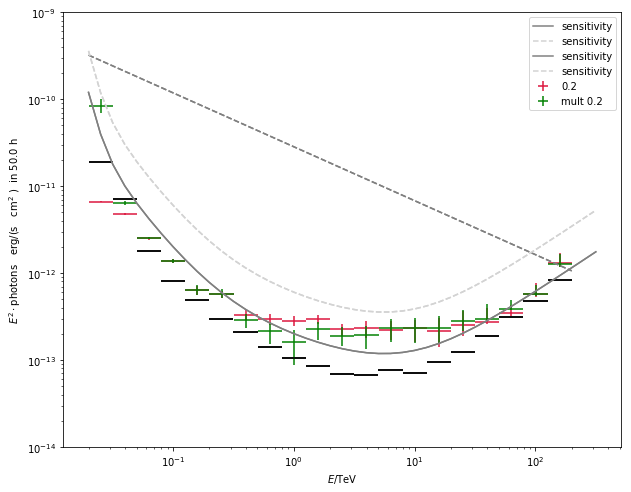

In [32]:
plt.figure(figsize=(10, 8))

# plot_sensitivity(rs_smooth, crab, bin_edges, bin_center, color='blue')

plot_sensitivity(rs_simple, crab, bin_edges, bin_center, color='crimson', label='0.2')
plot_sensitivity(rs_mult, crab, bin_edges, bin_center, color='green', label='mult 0.2')
# plot_sensitivity(rs_exact, crab, bin_edges, bin_center, color='blue', label='exact 0.2')

# plot_sensitivity(rs_interpolate, crab, bin_edges, bin_center, color='blue', label='interpolate')
# plot_sensitivity(rs_exact, crab, bin_edges, bin_center, color='green', label='exact')
plt.legend()

# plot_sensitivity(rs_simple_02, crab, bin_edges, bin_center, color='blue')


# plot_sensitivity(rs_smooth_02, crab, bin_edges, bin_center, color='navy')

Text(0.5,0,'Energy / TeV')

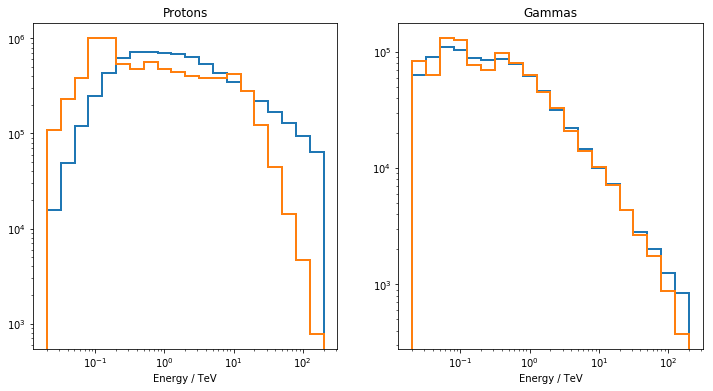

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(protons.mc_energy, bins=bin_edges, histtype='step', lw=2)
ax1.hist(protons.gamma_energy_prediction_mean, bins=bin_edges, histtype='step', lw=2)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title('Protons')
ax1.set_xlabel('Energy / TeV')

ax2.hist(gammas.mc_energy, bins=bin_edges, histtype='step', lw=2)
ax2.hist(gammas.gamma_energy_prediction_mean, bins=bin_edges, histtype='step', lw=2)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title('Gammas')
ax2.set_xlabel('Energy / TeV')